# P1 - TSA - Acceso a Internet en Colombia

Elaborado por GRUPO 1:
- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [18]:
# Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import plotly as pt
import plotly.express as px
import warnings
import Prophet

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from matplotlib import pyplot
from pandas import DatetimeIndex
from pandas import Series
from tabulate import tabulate

%matplotlib inline
sns.set()  

ModuleNotFoundError: No module named 'Prophet'

In [10]:
# Leer el archivo 'datos.csv'
df = pd.read_excel("DataSet/P1_Serie_Acceso_Internet_Trim.xlsx",index_col=0)

# Parte A. Contexto y relevancia del problema

### $\color{red}{\text{TODOS}}$ 

Para el desarrollo del proyecto, se utilizó la serie de tiempo del porcentaje de penetración de Internet dedicado en Colombia (% de la población).

Número de suscriptores con acceso a Internet, fijo y móvil, según los datos reportados por los proveedores al último día de cada trimestre como porcentaje de la población basados en las proyecciones de población del DANE.

Fuente: Ministerio de las TIC https://colombiatic.mintic.gov.co/

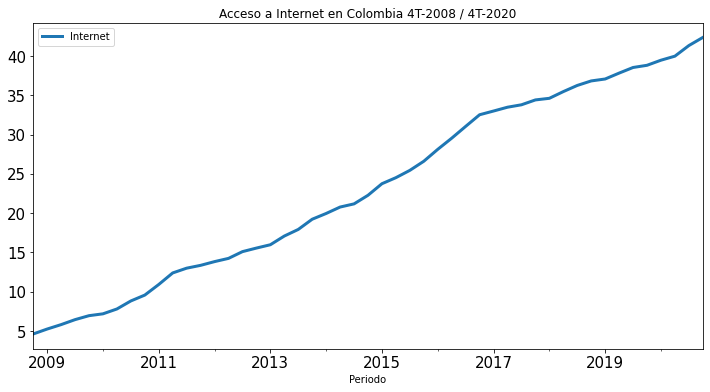

In [11]:
df.plot(figsize=(12, 6),linewidth=3, fontsize=15, title='Acceso a Internet en Colombia 4T-2008 / 4T-2020');

In [12]:
df.Internet.describe()

count    49.000000
mean     23.267556
std      11.852783
min       4.633165
25%      13.362776
50%      22.276354
75%      34.406101
max      42.350991
Name: Internet, dtype: float64

### Suscripciones a banda ancha fija (por cada 100 personas) en Latam

In [13]:
table_Latam = [['Colombia','13.8%'],['Argentina','19.6%'],['Brasil','15.6%'],['Ecuador','12.0%'],['Latam','14.1%'],['México','15.2%']]
headers = ['País', 'año 2018']
print(tabulate(table_Latam,headers))

NameError: name 'tabulate' is not defined

### Suscripciones a banda ancha fija (por cada 100 personas) en Países Desarrollados

In [6]:
table_GP = [['Alemania','42.0%'],['China','31.3%'],['Estados Unidos','34.7%'],['Japón','33.5%'],['OECD','31.8%'],['Reino Unido','39.7%']]
headers = ['País', 'año 2018']
print(tabulate(table_GP,headers))

País            año 2018
--------------  ----------
Alemania        42.0%
China           31.3%
Estados Unidos  34.7%
Japón           33.5%
OECD            31.8%
Reino Unido     39.7%


# Parte B. Análisis de los principales componentes de la serie

### $\color{red}{\text{JAIME}}$ 

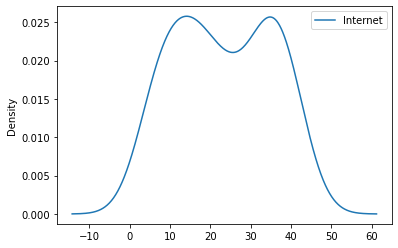

        Internet
count  49.000000
mean   23.267556
std    11.852783
min     4.633165
25%    13.362776
50%    22.276354
75%    34.406101
max    42.350991


In [37]:
df.plot(kind='kde')
plt.show()
print(df.describe())

## Prueba - Estacionariedad con tendencia

In [7]:
#DF Test
result = adfuller(df['Internet'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.040810
p-value: 0.955024
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


En este caso, el test no rechaza la Ho de que la serie no es estacionaria.

## Tendencia

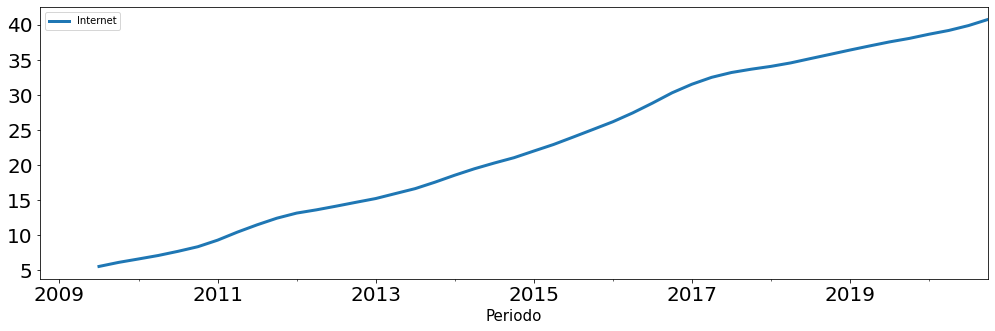

In [38]:
df.rolling(4).mean().plot(figsize=(17,5), linewidth=3, fontsize=20)
plt.xlabel('Periodo', fontsize=15);

## Serie sin Tendencia

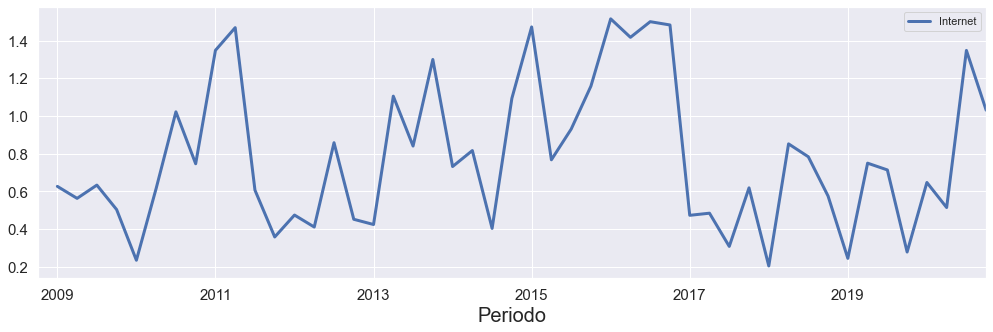

In [9]:
df.diff().plot(figsize=(17,5), linewidth=3, fontsize=15)
plt.xlabel('Periodo', fontsize=20);

## Prueba - Estacionariedad sin tendencia

In [10]:
result = adfuller(df['Internet'].diff().iloc [ 1 :]) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.179342
p-value: 0.000714
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


Al eliminar la tendencia, la serie es estacionaria.

# Autocorrelación

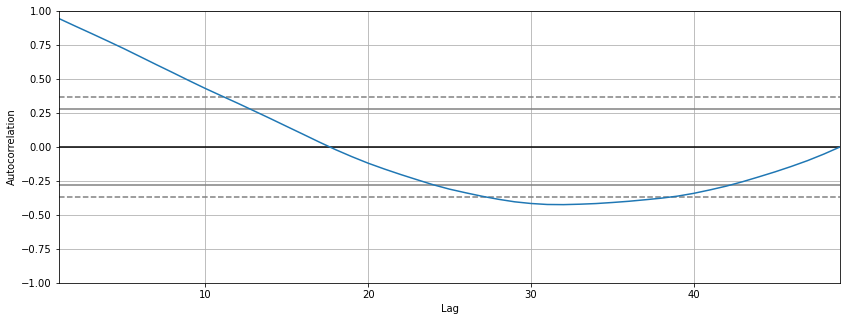

In [39]:
plt.figure(figsize=(14,5))
pd.plotting.autocorrelation_plot(df);

# Parte C. Modelos y Proyecciones

In [12]:
warnings.filterwarnings('ignore')

## C.1. Modelos ARIMA

### $\color{red}{\text{JUANITA-ALEX}}$ 

## 1. Modelos

Se transforma la serie en logaritmo y se diferencia una vez:

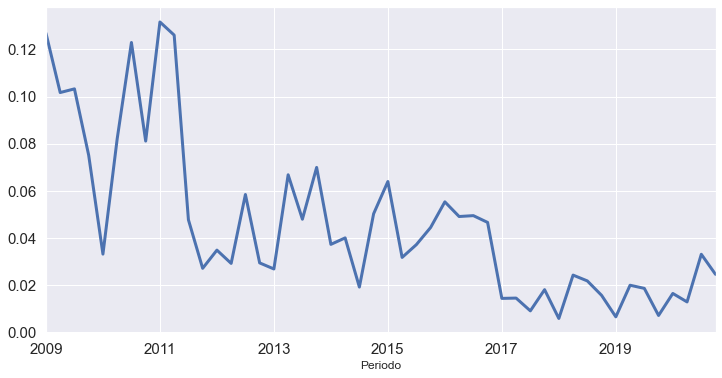

In [13]:
df['log_Internet'] = np.log(df['Internet'])
df_log=df.iloc[:,1:3]
df_log= df.log_Internet.diff()
df_log=df_log.dropna()
df_log.plot(figsize=(12, 6),linewidth=3, fontsize=15);

In [14]:
result = adfuller(df_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.297381
p-value: 0.014996
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


La serie diferenciada es estacionaria, dado que se rechaza la Ho de que la serie es no estacionaria.

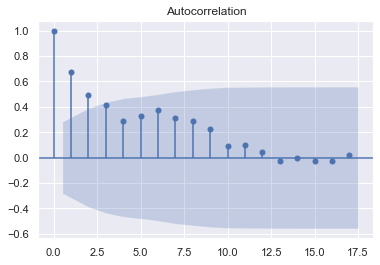

In [15]:
# Función de Autocorrelación
serie = np.log(df['Internet']).diff().dropna()
plot_acf(serie);

La ACF sugiere un proceso MA de orden 3.

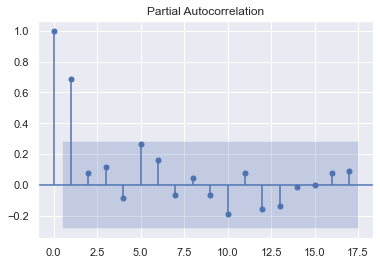

In [16]:
#Función de Autocorrelación Parcial
plot_pacf(serie);

La PACF sugiere un autorregresivo de orden 2.

A continuación se definen las bases de entrenamiento (80%) y de pruebas (20%):

In [17]:
#Bases de train y test
X = df['Internet'].values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
future = [x for x in test]

Se procede a estimar ahora los siguientes modelos:

### a. Modelo ARIMA(2,1,3)

In [18]:
# fit modelo 1 - ARIMA(2,1,3)
model1 = ARIMA(np.log(history), order=(2,1,3))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(2, 1, 3)   Log Likelihood                  83.129
Method:                       css-mle   S.D. of innovations              0.027
Date:                Wed, 14 Jul 2021   AIC                           -152.258
Time:                        08:17:39   BIC                           -140.795
Sample:                             1   HQIC                          -148.180
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0545      0.007      7.540      0.000       0.040       0.069
ar.L1.D.y      0.0528      0.118      0.449      0.653      -0.178       0.283
ar.L2.D.y      0.9472      0.120      7.869      0.0

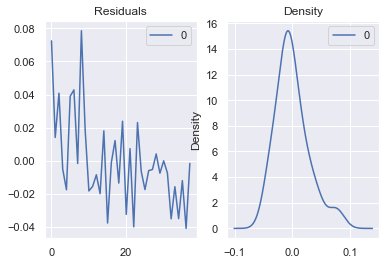

In [19]:
# plot residual errors
residuals = pd.DataFrame(model1_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

     predict       real
0  37.451142  36.247135
1  39.522632  36.822584
2  41.781185  37.067690
3  44.096223  37.817613
4  46.612087  38.531663
5  49.198848  38.810409
6  52.001781  39.457992
7  54.891700  39.972537
8  58.014906  41.320338
9  61.243051  42.350991


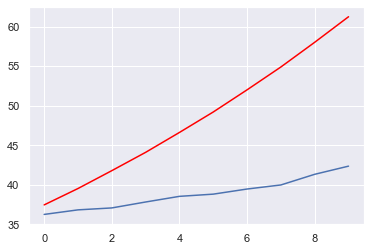

Test MSE: 125.914


In [20]:
# Real vs Proyectado
output = model1_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse1 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse1)

### b. Modelo ARIMA(2,1,1)

In [21]:
# fit modelo 2 - ARIMA(2,1,1)
model2 = ARIMA(np.log(history), order=(2,1,1))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  85.204
Method:                       css-mle   S.D. of innovations              0.025
Date:                Wed, 14 Jul 2021   AIC                           -160.409
Time:                        08:17:40   BIC                           -152.221
Sample:                             1   HQIC                          -157.496
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0558      0.010      5.442      0.000       0.036       0.076
ar.L1.D.y      1.6811      0.125     13.480      0.000       1.437       1.925
ar.L2.D.y     -0.6897      0.122     -5.644      0.0

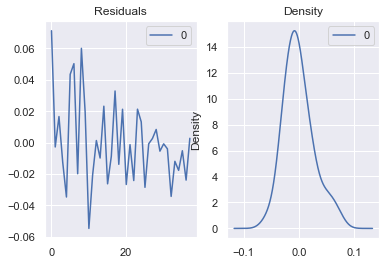

In [22]:
# plot residual errors
residuals = pd.DataFrame(model2_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

     predict       real
0  36.709762  36.247135
1  38.275843  36.822584
2  40.113104  37.067690
3  42.190137  37.817613
4  44.487033  38.531663
5  46.991943  38.810409
6  49.698846  39.457992
7  52.606069  39.972537
8  55.715259  41.320338
9  59.030679  42.350991


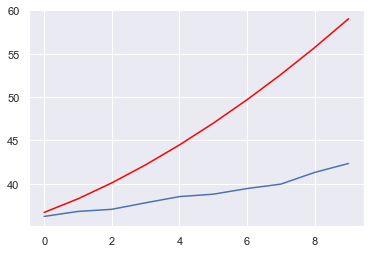

Test MSE: 88.303


In [23]:
#Real vs Proyectado
output = model2_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse2 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse2)

### c. Modelo ARIMA(2,1,0)

In [24]:
# fit modelo 3 - ARIMA(2,1,0)
model3 = ARIMA(np.log(history), order=(2,1,0))
model3_fit = model3.fit(disp=0)
print(model3_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  85.104
Method:                       css-mle   S.D. of innovations              0.026
Date:                Wed, 14 Jul 2021   AIC                           -162.208
Time:                        08:17:40   BIC                           -155.658
Sample:                             1   HQIC                          -159.877
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0560      0.013      4.198      0.000       0.030       0.082
ar.L1.D.y      0.6708      0.164      4.087      0.000       0.349       0.992
ar.L2.D.y      0.0358      0.172      0.208      0.8

     predict       real
0  36.651962  36.247135
1  38.125853  36.822584
2  39.843472  37.067690
3  41.777935  37.817613
4  43.911980  38.531663
5  46.235214  38.810409
6  48.742278  39.457992
7  51.431602  39.972537
8  54.304547  41.320338
9  57.364795  42.350991


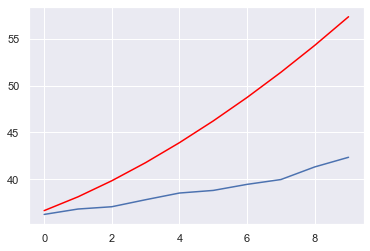

Test MSE: 72.084


In [25]:
#Real vs Proyectado
output = model3_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse3 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse3)

### d. Modelo ARIMA(1,1,1)

In [55]:
# fit modelo 4 - ARIMA(1,1,1)
model4 = ARIMA(np.log(history), order=(1,1,1))
model4_fit = model4.fit(disp=0)
print(model4_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  85.119
Method:                       css-mle   S.D. of innovations              0.026
Date:                Wed, 14 Jul 2021   AIC                           -162.237
Time:                        08:26:00   BIC                           -155.687
Sample:                             1   HQIC                          -159.907
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0561      0.014      4.078      0.000       0.029       0.083
ar.L1.D.y      0.7405      0.202      3.670      0.000       0.345       1.136
ma.L1.D.y     -0.0839      0.303     -0.277      0.7

     predict       real
0  36.627009  36.247135
1  38.063737  36.822584
2  39.738487  37.067690
3  41.627921  37.817613
4  43.716885  38.531663
5  45.996163  38.810409
6  48.460985  39.457992
7  51.109998  39.972537
8  53.944542  41.320338
9  56.968140  42.350991


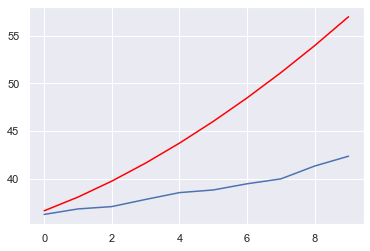

Test MSE: 67.999


In [56]:
#Real vs Proyectado
output = model4_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse4 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse4)

### e. Modelo ARIMA(1,2,1)

In [57]:
# fit modelo 5 - ARIMA(1,2,1)
model5 = ARIMA(np.log(history), order=(1,2,1))
model5_fit = model5.fit(disp=0)
print(model5_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   37
Model:                 ARIMA(1, 2, 1)   Log Likelihood                  85.663
Method:                       css-mle   S.D. of innovations              0.023
Date:                Wed, 14 Jul 2021   AIC                           -163.327
Time:                        08:26:13   BIC                           -156.883
Sample:                             2   HQIC                          -161.055
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.001     -4.013      0.000      -0.003      -0.001
ar.L1.D2.y     0.4191      0.159      2.640      0.008       0.108       0.730
ma.L1.D2.y    -1.0000      0.081    -12.341      0.0

     predict       real
0  36.006172  36.247135
1  36.370598  36.822584
2  36.612484  37.067690
3  36.755223  37.817613
4  36.808508  38.531663
5  36.776499  38.810409
6  36.661317  39.457992
7  36.464535  39.972537
8  36.187801  41.320338
9  35.833091  42.350991


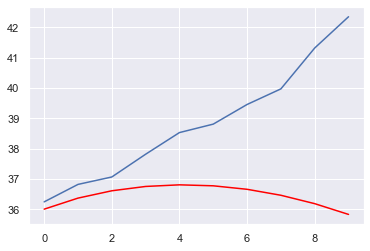

Test MSE: 9.766


In [58]:
#Real vs Proyectado
output = model5_fit.forecast(steps=len(test))[0]
yhat = output
predictions = np.exp(yhat)
real_values = future
print(pd.DataFrame({'predict':predictions, 'real':real_values}))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# MSE
mse5 = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse5)

### Comparación de modelos ARIMA

In [64]:
# Comparación de MSE
table_MSE = [['ARIMA (2,1,3)', round(mse1,3)],['ARIMA (2,1,1)', round(mse2,3)],['ARIMA (2,1,0)', round(mse3,3)],
            ['ARIMA (1,1,1)', round(mse4,3)],['ARIMA (1,2,1)', round(mse5,3)]]
headers = ['Modelo', 'MSE ']
print(tabulate(table_MSE,headers,stralign="decimal"))

       Modelo     MSE
-------------  -------
ARIMA (2,1,3)  125.914
ARIMA (2,1,1)   88.303
ARIMA (2,1,0)   72.084
ARIMA (1,1,1)   67.999
ARIMA (1,2,1)    9.766


Se selecciona el modelo ARIMA(1,2,1) por tener menor MSE.

## 2. Proyección a 2 años (fuera de la muestra)

In [59]:
#Modelo final con todos los datos
model_def = ARIMA(np.log(X), order=(1,2,1))
model_def_fit = model_def.fit(disp=0)
print(model_def_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   47
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 113.153
Method:                       css-mle   S.D. of innovations              0.021
Date:                Wed, 14 Jul 2021   AIC                           -218.306
Time:                        08:26:39   BIC                           -210.906
Sample:                             2   HQIC                          -215.521
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.000     -4.872      0.000      -0.003      -0.001
ar.L1.D2.y     0.4445      0.141      3.158      0.002       0.169       0.720
ma.L1.D2.y    -1.0000      0.069    -14.513      0.0

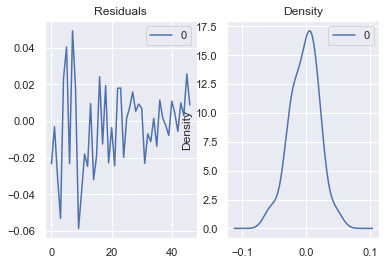

In [60]:
# plot residual errors
residuals = pd.DataFrame(model_def_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

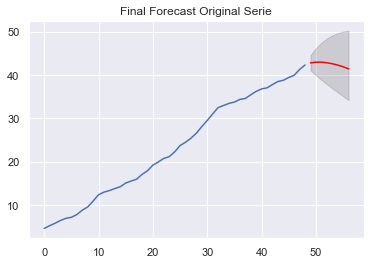

In [61]:
#Proyección por fuera de la muestra
n_periods = 8
fc, se, conf = model_def_fit.forecast(steps=n_periods)

#Extraer series
index_of_fc = np.arange(len(X), len(X)+n_periods)
fc_serie = np.exp(pd.Series(fc, index=index_of_fc))
lower_serie = np.exp(pd.Series(conf[:, 0], index=index_of_fc))
upper_serie = np.exp(pd.Series(conf[:, 1], index=index_of_fc))

# Gráfico
plt.plot(X)
plt.plot(fc_serie, color='red')
plt.fill_between(lower_serie.index,lower_serie, upper_serie, 
                 color='k', alpha=.15)
plt.title("Final Forecast Original Serie")
plt.show()

In [62]:
trimestres=['1T-21','2T-21','3T-21','4T-21','1T-22','2T-22','3T-22','4T-22']
trimestres=pd.DataFrame(trimestres)
table_proy = [[trimestres[-0],round(fc_serie[:],1), round(lower_serie,1), round(upper_serie,1)]]
headers = ['Periodo','Proyección', 'Límite inferior','Límite superior']
print(tabulate(table_proy,headers))

Periodo                 Proyección      Límite inferior    Límite superior
----------------------  --------------  -----------------  -----------------
0    1T-21              49    42.8      49    41.1         49    44.6
1    2T-21              50    43.0      50    40.0         50    46.2
2    3T-21              51    43.0      51    38.9         51    47.5
3    4T-21              52    42.9      52    37.9         52    48.4
4    1T-22              53    42.6      53    37.0         53    49.2
5    2T-22              54    42.3      54    36.0         54    49.7
6    3T-22              55    41.9      55    35.1         55    50.1
7    4T-22              56    41.5      56    34.2         56    50.2
Name: 0, dtype: object  dtype: float64  dtype: float64     dtype: float64


## C.2. Modelo Prophet

In [2]:
df['log_Colombia'] = np.log(df['Colombia'])
df_log1=df.iloc[:,1:3]
df_log1= df.log_Colombia.diff()
df_log1=df_log1.dropna()

NameError: name 'np' is not defined

In [1]:
# Ajuste de Dataframe para que ds tenga formato fecha
df_.dtypes
df_['ds'] = pd.DatetimeIndex(df_['ds'])
df_.dtypes

NameError: name 'df_' is not defined

In [7]:
df_.head()

NameError: name 'df_' is not defined

## 1. Modelo ###

In [36]:
m = Prophet()
m.fit(df_)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

## 2. Proyección a 5 años (fuera de la muestra) ###

In [ ]:
future = m.make_future_dataframe(periods=60, freq='MS')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

# Plotting the Forecast

In [ ]:
m.plot(forecast);

# Decomposing the Forecast

In [ ]:
m.plot_components(forecast);

# Cross-validation

In [ ]:
from fbprophet.diagnostics import cross_validation

cutoffs = pd.date_range(start='2019-01-01', end='2020-11-01', freq='3MS')
print(cutoffs)

df_cv = cross_validation(model=m, horizon='180 days', cutoffs=cutoffs)

In [ ]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

performance_metrics(df_cv)

In [ ]:
plot_cross_validation_metric(df_cv, metric='mae');

# Conclusiones

### $\color{red}{\text{TODOS}}$ 